In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# -*- coding: utf-8 -*-

import sys
import copy
import pandas as pd
import numpy as np
import datetime

from matplotlib import pyplot as plt

from pint import UnitRegistry
ur = UnitRegistry(autoconvert_offset_to_baseunit = True)


BOXSIMU_PATH = '/home/aschi/Documents/MyPrivateRepo/notebooks/'
if not BOXSIMU_PATH in sys.path:
    sys.path.append(BOXSIMU_PATH)

from boxsimu import (Fluid, Variable, Box, Flow, Condition, 
                     BoxModelSystem, Process, Reaction, Flux)
from boxsimu import utils


#############################
# FLUIDS
#############################
# water density parameters
def init_simu1():
    A = 0.14395
    B = 0.0112
    C = 649.727*ur.kelvin
    D = 0.05107
    rho_expr_water = lambda time, c: A / (B**(1+(1-(c.T/C))**D))*ur.kg/ur.meter**3
    
    water = Fluid('water', rho_expr=rho_expr_water, mass=8e5*ur.kg)
    lakewater = copy.deepcopy(water)
    lakewater.mass = 8e4*ur.kg
    
    #############################
    # CONDITIONS
    #############################
    condition_lake = Condition(T=290*ur.kelvin, pH=5)
    condition_upper_ocean = Condition(T=280*ur.kelvin)
    condition_deep_ocean = Condition(T=275*ur.kelvin)
    
    #############################
    # VARIABLES
    #############################
    phosphate = Variable('PO4')
    nitrate = Variable('NO3')
    organic_compound1 = Variable('OC1')
    phyto = Variable('phyto')
    
    #############################
    # PROCESSES
    #############################
    process_photolytic_deg_rate = lambda t, c: -max(0,((- 10*ur.kelvin*np.cos(2*np.pi*t / (24*ur.hour))) / (10*ur.kelvin))) * 10*ur.gram/ur.hour
    process_photolytic_deg = Process(
            'Photolytic Degradation',
            organic_compound1, 
            process_photolytic_deg_rate
    ) 
    
    #############################
    # REACTIONS
    #############################
    reaction_photosynthesis = Reaction(
        name = 'Photosynthesis',
        variables = [nitrate, phosphate, phyto],
        variable_coeffs=[-7.225, -1, + 114.5],  # Redfield ratio in weight instead of mol
        rate=lambda t, c: (max(0,((- 10*ur.kelvin*np.cos(2*np.pi*t / (24*ur.hour))) / (10*ur.kelvin))) * 10)**1.4 *ur.gram/ur.hour
    )
    
    #############################
    # BOXES
    #############################
    lake = Box(
        name='lake',
        name_long='Medium Size Lake',
        fluid=lakewater,
        #processes=[process_photolytic_deg,],
        #reactions=[reaction_photosynthesis, ],
        variables=[phosphate.q(1*ur.kg),], # organic_compound1],
        condition=condition_lake,
    )
    upper_ocean = Box(
        name='upper_ocean',
        name_long='Upper Ocean Box',
        fluid=water, 
        #processes=[process_photolytic_deg,],
        reactions=[],
        variables=[phosphate.q(1*ur.kg), ],
        condition=condition_upper_ocean,
    )
    deep_ocean = Box(
        name='deep_ocean',
        name_long='Deep Ocean Box', 
        fluid=water, 
        processes=[],
        variables=[nitrate.q(2*ur.kg), ],
        condition=condition_deep_ocean,
    )
    
    
    #############################
    # FLOWS
    #############################
    f1 = Flow(
        name='River flow from Lake to Ocean', 
        source_box=lake, 
        target_box=upper_ocean,
        rate=0.2e5*ur.kg/ur.hour,
    )
    f2 = Flow(
        name='Downwelling', 
        source_box=upper_ocean, 
        target_box=deep_ocean,
        rate=lambda t, c: 2.6e5*ur.kg/ur.hour, 
    )
    f3 = Flow(
        name='Upwelling',
        source_box=deep_ocean, 
        target_box=upper_ocean,
        rate=lambda t, c: 2.5e5*ur.kg/ur.hour, 
    )
    f4 = Flow(
        name='Deep Sea Percolation into Earth-Interior',
        source_box=deep_ocean, 
        target_box=None,
        rate=lambda t, c: 0.09e5*ur.kg/ur.hour, 
    )
    f5 = Flow(
        name='Rain',
        source_box=None, 
        target_box=lake,
        rate=lambda t, c: min(min(np.exp(t/(8000*ur.hour)),5)*0.1e5*ur.kg/ur.hour, 0.25e5*ur.kg/ur.hour), 
    )
    
    #############################
    # FLUXES
    #############################
    
    flux1 = Flux('Biological pump', upper_ocean, deep_ocean, phyto, lambda t, c: c.box1.variables.phyto.mass * 0.1 / ur.day)
    
    
    
    #############################
    # SYSTEM
    #############################
    sys = BoxModelSystem('Test System', 
                          [lake, upper_ocean, deep_ocean], 
                          Condition(T=301.11, pH=8.3),
                          flows=[f1,f2,f3,f4,f5],
                          #fluxes=[flux1, ],
    )
    return sys

In [4]:
sys = init_simu1()

> /home/aschi/Documents/MyPrivateRepo/notebooks/boxsimu/system.py(476)solve_flows()
-> print('Start solving the flows of the box model...')
(Pdb) n
Start solving the flows of the box model...
> /home/aschi/Documents/MyPrivateRepo/notebooks/boxsimu/system.py(477)solve_flows()
-> print('- integration time: {}'.format(total_integration_time))
(Pdb) 
- integration time: 15000 hour
> /home/aschi/Documents/MyPrivateRepo/notebooks/boxsimu/system.py(478)solve_flows()
-> print('- time step: {}'.format(dt))
(Pdb) 
- time step: 75.0 hour
> /home/aschi/Documents/MyPrivateRepo/notebooks/boxsimu/system.py(481)solve_flows()
-> N_time_steps = int(total_integration_time/dt)
(Pdb) 
> /home/aschi/Documents/MyPrivateRepo/notebooks/boxsimu/system.py(482)solve_flows()
-> time = total_integration_time * 0
(Pdb) 
> /home/aschi/Documents/MyPrivateRepo/notebooks/boxsimu/system.py(485)solve_flows()
-> start_time = time_module.time()
(Pdb) 
> /home/aschi/Documents/MyPrivateRepo/notebooks/boxsimu/system.py(487)sol

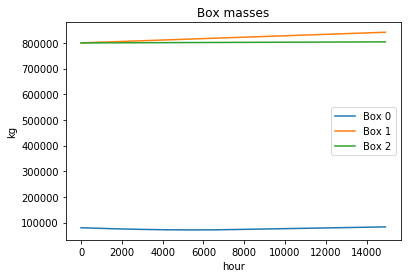

In [7]:
sys = init_simu1()
sol = sys.solve_flows(15000*ur.hour, 15000.0/200*ur.hour, debug=False)
sol.plot_box_masses()

Start solving the box model...
- integration time: 15000 hour
- time step: 15 minute
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%
Function "solve(...)" used 892.370s
2 2
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd50e3084e0>
i: 0
x=0  y=0
i: 1
x=1  y=0
i: 2
x=0  y=1
2017-06-20 12:34:28.587647


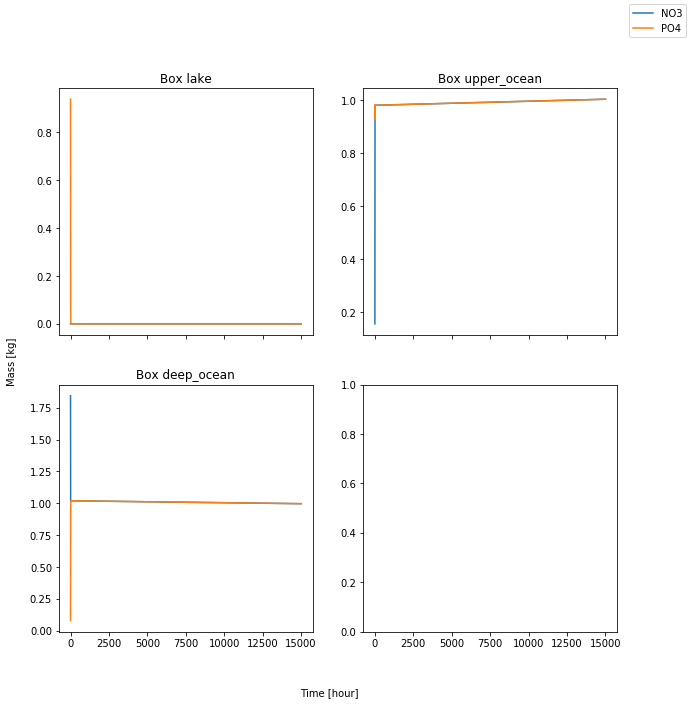

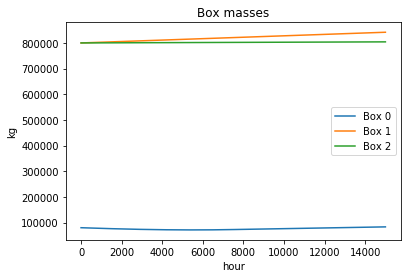

In [9]:
sys = init_simu1()
total_integration_time = 15000*ur.hour
dt = 15*ur.minute
sol = sys.solve(total_integration_time, dt, debug=False)
sol.plot_variables_masses(['NO3', 'PO4'])
sol.plot_box_masses()

print(datetime.datetime.now())

In [ ]:
dimless

In [19]:
sys.boxes.upper_ocean.variables.NO3.test123_upper_ocean = 1
sys.boxes.deep_ocean.variables.NO3.test123_deep_ocean = 2
sys.boxes.lake.variables.NO3.test123_lake = 3

In [21]:
sys.boxes.deep_ocean.variables.NO3.test123_deep_ocean

2

In [10]:
6e4/9e2

66.66666666666667